In [1]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD

import os
import numpy as np
from scipy.signal import decimate
from tensorflow.keras import regularizers
from poseidon.signal.lofar import tpsw, lofar
from poseidon.io.offline import load_raw_data
from poseidon.signal.utils import resample

In [42]:
from itertools import product
p_modes = frequency_decimation_blocks.keys()
t_modes = background_noise_correction_blocks.keys()
e_modes = individual_spectrum_normalization_blocks.keys()
f_modes = frequency_bin_normalization_blocks.keys()
mode_combinations = list(product(p_modes, t_modes, e_modes, f_modes))

288

In [85]:
def rms(x):
    return np.sqrt((x**2).sum()/x.shape[0])

frequency_decimation_blocks = {
    'P1': lambda Sxx: decimate(decimate(Sxx, 
                                        2, 1, ftype='fir'), 
                               2, 1, ftype='fir'),
    'P2': lambda Sxx: decimate(Sxx, 2, 1, ftype='fir'),
    'P3': lambda Sxx: Sxx
}

background_noise_correction_blocks = {
    'T1': lambda Sxx: Sxx,
    'T2': lambda Sxx: Sxx - tpsw(Sxx),
    'T3': lambda Sxx: (Sxx - tpsw(Sxx))/tpsw(Sxx),
    'T4': lambda Sxx: Sxx/tpsw(Sxx),
    'T5': lambda Sxx: np.log10(Sxx/tpsw(Sxx)),
    'T6': lambda Sxx: np.log10(Sxx)
}

individual_spectrum_normalization_blocks = {
    'E1': lambda Sxx: Sxx,
    'E2': lambda Sxx: Sxx/Sxx.max(),
    'E3': lambda Sxx: Sxx/rms(Sxx),
    'E4': lambda Sxx: Sxx/Sxx.mean(),
}

frequency_bin_normalization_blocks = {
    'F1': lambda tst_bin, trn_bins: tst_bin,
    'F2': lambda tst_bin, trn_bins: tst_bin/trn_bins.mean(),
    'F3': lambda tst_bin, trn_bins: (tst_bin - trn_bins.mean())/trn_bins.mean(),
    'F4': lambda tst_bin, trn_bins: (tst_bin - trn_bins.mean())/rms(tst_bin - trn_bins.mean())
}


In [83]:
## Frequency decimation test
nbins = 800
freq_dec_test_data = np.ones(nbins)
for mode, c_bins in zip(['P3', 'P2', 'P1'], [nbins, nbins//2, nbins//4]):
    assert frequency_decimation_blocks[mode](freq_dec_test_data).ndim == 1
    assert frequency_decimation_blocks[mode](freq_dec_test_data).shape[0] == c_bins

## Background noise correction test

In [18]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
database = '4classes'
proc_data_path = os.path.join(base_dir, 'data', 'processed')
raw_data_path = os.path.join(base_dir, 'data', 'raw', database)
raw_data = load_raw_data(raw_data_path, verbose=0)

In [85]:
ex_data = (raw_data
    .apply(lambda rr: rr.signal)
    .apply(decimate,
           signal_proc_params['decimation_rate'], 8, 'fir', zero_phase=True)
    .apply(spectrogram,
           **spectrogram_args)
    .apply(lambda x: np.transpose(x[2])))['Class_22']['class22_dataset24B.wav'][0] # remove time and freq info/transpose power spectrum

In [60]:
ex_data[ex_data < 0.00008] = np.sqrt(ex_data[ex_data < 0.00008])**(1.5)
# ex_data[ex_data < ]

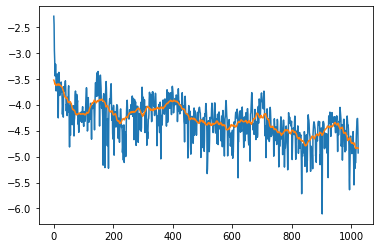

In [87]:

plt.plot(np.log10(ex_data))
plt.plot(np.log10(tpsw(ex_data)))

In [33]:
from scipy.signal import spectrogram

signal_proc_params = dict(
    n_pts_fft = 2048,
    n_overlap = 0,
    decimation_rate = 3,
    fs=22050,
    spectrum_bins_left=800
)

spectrogram_args = dict(
    window=('hann'),
    fs=signal_proc_params['fs']//signal_proc_params['decimation_rate'],
    nfft = signal_proc_params['n_pts_fft'], 
    nperseg = signal_proc_params['n_pts_fft'], 
    noverlap=signal_proc_params['n_overlap'],
    detrend=False,
    axis=0,
    scaling='spectrum',
    mode='magnitude'
)

def cut_bins(sxx, spectrum_bins_left):
    return sxx[:, :spectrum_bins_left]

def preprocess_data(raw_data, p_mode, t_mode, e_mode):
    return (
        raw_data
            .apply(lambda rr: rr.signal)
            .apply(decimate,
                   signal_proc_params['decimation_rate'], 8, 'fir', zero_phase=True)
            .apply(spectrogram,
                   **spectrogram_args)
            .apply(lambda x: np.transpose(x[2])) # remove time and freq info/transpose power spectrum
            .apply(cut_bins, signal_proc_params['spectrum_bins_left'])
            .apply(frequency_decimation_blocks[p_mode])
            .apply(background_noise_correction_blocks[t_mode])
            .apply(individual_spectrum_normalization_blocks[e_mode])
    )

def generate_data_trgt_pair(processed_data_dict, trgt_label_map=None):
    if trgt_label_map is None:
        trgt_label_map = {
            'ClassA': 0,
            'ClassB': 1,
            'ClassC': 2,
            'ClassD': 3
        }
    
    trgt = np.concatenate([trgt_label_map[cls_name]*np.ones(Sxx.shape[0]) 
                     for cls_name, run in processed_data_dict.items() 
                     for run_name, Sxx in run.items()])
    data = np.concatenate([Sxx
                     for cls_name, run in processed_data_dict.items() 
                     for run_name, Sxx in run.items()], axis=0)
    return data, trgt

data, trgt = generate_data_trgt_pair(
    preprocess_data(raw_data, 'P3', 'T1', 'E1')
)
# data = preprocess_data(raw_data, 'P1', 'T1', 'E1')
# for cls_name, run in data.items():
#     for run_name, Sxx in run.items():
#         print(cls_name, end=' ')
#         print(run_name, end=' ')
#         print(Sxx.shape)
data.shape

(12911, 800)

In [87]:
import time
start = time.time()
result1 = [frequency_bin_normalization_blocks['F4'](data[:, i_bin], data[:, i_bin])
           for i_bin in range(data.shape[1])]
        
print(time.time() - start)
data.shape

0.4544961452484131


(12911, 800)